In [1]:
import sys
print sys.prefix
print sys.version
spark_home = "C:\spark152"
# spark_home = "/opt/mapr/spark/spark1.6.1"

c:\anaconda2\envs\mypy
2.7.12 |Continuum Analytics, Inc.| (default, Jun 29 2016, 11:07:13) [MSC v.1500 64 bit (AMD64)]


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
import drill_utilities as du
%matplotlib inline

# Connection to Drill database

In [3]:
#
# Drillbit ODBC connection
#
conn = du.DrillODBC("drill_eds")

## Order data by form

In [4]:
q1 = "select id_form, id_nda, champ_formulaire, CAST(LWERT as VARCHAR) as value_field, j1 \
from saps2_forms where champ_formulaire like 'int_esc%' \
        or champ_formulaire in ('int_maladies_chronique', 'int_igs2') \
        order by id_form, id_nda, champ_formulaire"
df1 = conn.df_from_query(q1)
df1.head()

,id_form,id_nda,champ_formulaire,value_field,j1
0,9028131,676475,int_esc_admission,0,None
1,9028131,676475,int_esc_age,16,None
2,9028131,676475,int_esc_bicarbonate,3,None
3,9028131,676475,int_esc_bilirubine,0,None
4,9028131,676475,int_esc_diurese,0,None


In [5]:
q2 = "select distinct id_form, id_nda, dt_ins, j1 from saps2_forms \
where champ_formulaire like 'int_esc%' \
        or champ_formulaire = 'int_maladies_chronique'"
df2 = conn.df_from_query(q2)
df2['dt_ins'] = pd.to_datetime(df2['dt_ins'])
df2['j1'] = pd.to_datetime(df2['j1'])
df2.head(10)

,id_form,id_nda,dt_ins,j1
0,9028131,676475,2012-11-29 18:29:19,NaT
1,9040832,676475,2012-11-30 07:28:11,NaT
2,9972417,669364,2012-12-13 18:50:32,NaT
3,9972490,704443,2012-12-13 18:53:53,NaT
4,9972629,706030,2012-12-13 19:04:06,NaT
5,9972555,669364,2012-12-13 19:13:09,NaT
6,9973606,668052,2012-12-14 00:18:14,NaT
7,9984881,738250,2012-12-14 09:14:22,NaT
8,10017517,741648,2012-12-15 15:42:50,NaT
9,10030449,741967,2012-12-16 07:28:21,NaT


In [6]:
import warnings
warnings.filterwarnings('ignore')

df2.ix[df2['j1'].notnull(), 'dt_ins'] = df2.ix[df2['j1'].notnull(), 'j1']
df2.drop('j1', axis=1, inplace=True)
df2.head(10)

,id_form,id_nda,dt_ins
0,9028131,676475,2012-11-29 18:29:19
1,9040832,676475,2012-11-30 07:28:11
2,9972417,669364,2012-12-13 18:50:32
3,9972490,704443,2012-12-13 18:53:53
4,9972629,706030,2012-12-13 19:04:06
5,9972555,669364,2012-12-13 19:13:09
6,9973606,668052,2012-12-14 00:18:14
7,9984881,738250,2012-12-14 09:14:22
8,10017517,741648,2012-12-15 15:42:50
9,10030449,741967,2012-12-16 07:28:21


In [7]:
print(len(df1), len(df2))

(273344, 17084)


In [8]:
from time import strftime

# merging datasets
result =  pd.merge(df1,df2[['id_form', 'dt_ins']], how='inner', on=['id_form'])
print(len(result))
result.drop('j1', axis=1, inplace=True)
result['id_nda'] = result.id_nda.str.cat(result.dt_ins.dt.strftime('%Y-%m-%d'))
result['id_nda'] = result.id_nda + "_"
result['id_nda'] = result.id_nda.str.cat(result.id_form.astype(str))
result.drop('dt_ins', axis=1, inplace=True)
result.drop('id_form', axis=1, inplace=True)
result.columns = ['id_form_ndaj1', 'champ_formulaire', 'value_field']
result.head(30)

273344


,id_form_ndaj1,champ_formulaire,value_field
0,6764752012-11-29_9028131,int_esc_admission,0
1,6764752012-11-29_9028131,int_esc_age,16
2,6764752012-11-29_9028131,int_esc_bicarbonate,3
3,6764752012-11-29_9028131,int_esc_bilirubine,0
4,6764752012-11-29_9028131,int_esc_diurese,0
5,6764752012-11-29_9028131,int_esc_frequence,0
6,6764752012-11-29_9028131,int_esc_glasgow,0
7,6764752012-11-29_9028131,int_esc_globules,0
8,6764752012-11-29_9028131,int_esc_kaliemie,3
9,6764752012-11-29_9028131,int_esc_natremie,0


In [9]:
# pivot dataframe to get matrix
result = result.pivot(index='id_form_ndaj1',columns='champ_formulaire', values='value_field')
print(len(result))
result.head()

17084


champ_formulaire,int_esc_admission,int_esc_age,int_esc_bicarbonate,int_esc_bilirubine,int_esc_diurese,int_esc_frequence,int_esc_glasgow,int_esc_globules,int_esc_kaliemie,int_esc_natremie,int_esc_pao2,int_esc_pression,int_esc_temperature,int_esc_uree,int_igs2,int_maladies_chronique
id_form_ndaj1,,,,,,,,,,,,,,,,
100012892016-05-23_289481217,6,0,0,4,0,2,0,0,0,0,0,5,0,0,17,0
100050472016-07-05_319660691,0,7,0,0,0,0,0,0,0,0,0,0,0,0,16,9
100061012016-05-21_288477268,6,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0
100065192016-06-22_310409510,0,15,0,0,0,0,0,0,3,0,0,0,0,0,18,0
100071702016-05-20_287829904,6,12,6,0,11,11,26,0,3,0,6,13,0,0,94,0


In [10]:
result['id_ndaj1'] = result.index.str.extract('(.*)_.*')
result.head()

champ_formulaire,int_esc_admission,int_esc_age,int_esc_bicarbonate,int_esc_bilirubine,int_esc_diurese,int_esc_frequence,int_esc_glasgow,int_esc_globules,int_esc_kaliemie,int_esc_natremie,int_esc_pao2,int_esc_pression,int_esc_temperature,int_esc_uree,int_igs2,int_maladies_chronique,id_ndaj1
id_form_ndaj1,,,,,,,,,,,,,,,,,
100012892016-05-23_289481217,6,0,0,4,0,2,0,0,0,0,0,5,0,0,17,0,100012892016-05-23
100050472016-07-05_319660691,0,7,0,0,0,0,0,0,0,0,0,0,0,0,16,9,100050472016-07-05
100061012016-05-21_288477268,6,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,100061012016-05-21
100065192016-06-22_310409510,0,15,0,0,0,0,0,0,3,0,0,0,0,0,18,0,100065192016-06-22
100071702016-05-20_287829904,6,12,6,0,11,11,26,0,3,0,6,13,0,0,94,0,100071702016-05-20


## Save dataframe as Parquet Table

In [11]:
import os
print(spark_home)
os.environ['SPARK_HOME'] = spark_home
os.environ['PYSPARK_DRIVER_PYTHON'] ="jupyter"
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']="notebook"
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.8.2.1-src.zip'))

C:\spark152


In [16]:
import spark_util as su
sc = su.SparkClient(spark_home, exec_memory="4g")

In [17]:
spark_df = sc._sql.createDataFrame(result)
spark_df.write.parquet("d:/tmp/EDS_TABLES"+"/igs2_matrix1", mode='overwrite')

Traceback (most recent call last):
  File "c:\anaconda2\envs\mypy\lib\SocketServer.py", line 290, in _handle_request_noblock
    self.process_request(request, client_address)
  File "c:\anaconda2\envs\mypy\lib\SocketServer.py", line 318, in process_request
    self.finish_request(request, client_address)
  File "c:\anaconda2\envs\mypy\lib\SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "c:\anaconda2\envs\mypy\lib\SocketServer.py", line 652, in __init__
    self.handle()
  File "C:\spark152\python\pyspark\accumulators.py", line 235, in handle


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 50627)
----------------------------------------


In [ ]:
sc._sc.stop()

In [11]:
# create table mapping id_nda with id_patient
q_map_nda_pat = "drop table map_nda_pat"
try:
    conn._conn.execute(q_map_nda_pat)
except:
    pass

q_map_nda_pat = "create table map_nda_pat as \
select distinct i.id_ndaj1, n.ids_pat \
from igs2_matrix1 i, nda_mouv_ufr_tr n \
where CAST(n.id_nda as VARCHAR)=SUBSTR(i.id_ndaj1,1,CHAR_LENGTH(i.id_ndaj1)-10)"
conn._conn.execute(q_map_nda_pat)

# select i.id_ndaj1, n.ids_pat, p.dt_deces
# from igs2_matrix1 i, nda_mouv_ufr_tr n, patient_tr p
# where CAST(n.id_nda as VARCHAR)=SUBSTR(i.id_ndaj1,1,CHAR_LENGTH(i.id_ndaj1)-10)
# and CAST(n.ids_pat as VARCHAR) = CAST(p.ids_pat as VARCHAR)
# limit 10;

# select distinct i.id_ndaj1, n.ids_pat
# from igs2_matrix1 i, nda_mouv_ufr_tr n
# where CAST(n.id_nda as VARCHAR)=SUBSTR(i.id_ndaj1,1,CHAR_LENGTH(i.id_ndaj1)-10)
# limit 10;


In [11]:
# get dt_deces for all patients found
q = "select m.id_ndaj1, p.dt_deces \
from map_nda_pat m, patient_tr p \
where m.ids_pat = p.ids_pat"

additional_result = conn.df_from_query(q)

print(len(additional_result))

16332


In [12]:
# join to result
resultf = pd.merge(result, additional_result, how='inner', on=['id_ndaj1'])
print(len(resultf))
resultf.head()

17099


champ_formulaire,int_esc_admission,int_esc_age,int_esc_bicarbonate,int_esc_bilirubine,int_esc_diurese,int_esc_frequence,int_esc_glasgow,int_esc_globules,int_esc_kaliemie,int_esc_natremie,int_esc_pao2,int_esc_pression,int_esc_temperature,int_esc_uree,int_igs2,int_maladies_chronique,id_ndaj1,dt_deces
0,6,0,0,4,0,2,0,0,0,0,0,5,0,0,17,0,100012892016-05-23,NaT
1,0,7,0,0,0,0,0,0,0,0,0,0,0,0,16,9,100050472016-07-05,NaT
2,6,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,100061012016-05-21,NaT
3,0,15,0,0,0,0,0,0,3,0,0,0,0,0,18,0,100065192016-06-22,NaT
4,6,12,6,0,11,11,26,0,3,0,6,13,0,0,94,0,100071702016-05-20,2016-05-20 04:45:00


In [13]:
resultf.index = resultf['id_ndaj1']

In [14]:
resultf.head()

champ_formulaire,int_esc_admission,int_esc_age,int_esc_bicarbonate,int_esc_bilirubine,int_esc_diurese,int_esc_frequence,int_esc_glasgow,int_esc_globules,int_esc_kaliemie,int_esc_natremie,int_esc_pao2,int_esc_pression,int_esc_temperature,int_esc_uree,int_igs2,int_maladies_chronique,id_ndaj1,dt_deces
id_ndaj1,,,,,,,,,,,,,,,,,,
100012892016-05-23,6,0,0,4,0,2,0,0,0,0,0,5,0,0,17,0,100012892016-05-23,NaT
100050472016-07-05,0,7,0,0,0,0,0,0,0,0,0,0,0,0,16,9,100050472016-07-05,NaT
100061012016-05-21,6,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,100061012016-05-21,NaT
100065192016-06-22,0,15,0,0,0,0,0,0,3,0,0,0,0,0,18,0,100065192016-06-22,NaT
100071702016-05-20,6,12,6,0,11,11,26,0,3,0,6,13,0,0,94,0,100071702016-05-20,2016-05-20 04:45:00


In [15]:
# resultf[resultf['int_esc_admission'].isnull()]

In [16]:
len(resultf)

17099

In [17]:
# mortality rate
mr = float(resultf[resultf['dt_deces'].notnull()].shape[0]) / float(resultf.shape[0]) * 100.
print("Mortality rate: {}".format(mr))

Mortality rate: 19.5625475174


In [18]:
# compute logit and SAPS2 mortality probability
# Logit = -7.7631+0.0737*IGS2+0.9971*log(IGS2+1)
# Probabilité =e(Logit)/(1+e(Logit))
resultf['logit'] = -7.7631+0.0737*resultf['int_igs2'].astype('float') + 0.9971*np.log(resultf['int_igs2'].astype('float')+1.)
resultf['pr'] = np.exp(resultf['logit']) / (1. + np.exp(resultf['logit']))

In [19]:
resultf.head()

champ_formulaire,int_esc_admission,int_esc_age,int_esc_bicarbonate,int_esc_bilirubine,int_esc_diurese,int_esc_frequence,int_esc_glasgow,int_esc_globules,int_esc_kaliemie,int_esc_natremie,int_esc_pao2,int_esc_pression,int_esc_temperature,int_esc_uree,int_igs2,int_maladies_chronique,id_ndaj1,dt_deces,logit,pr
id_ndaj1,,,,,,,,,,,,,,,,,,,,
100012892016-05-23,6,0,0,4,0,2,0,0,0,0,0,5,0,0,17,0,100012892016-05-23,NaT,-3.628210,0.025876
100050472016-07-05,0,7,0,0,0,0,0,0,0,0,0,0,0,0,16,9,100050472016-07-05,NaT,-3.758903,0.022778
100061012016-05-21,6,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,100061012016-05-21,NaT,-5.380633,0.004584
100065192016-06-22,0,15,0,0,0,0,0,0,3,0,0,0,0,0,18,0,100065192016-06-22,NaT,-3.500600,0.029295
100071702016-05-20,6,12,6,0,11,11,26,0,3,0,6,13,0,0,94,0,100071702016-05-20,2016-05-20 04:45:00,3.705371,0.975999


In [20]:
# test score igs2
y_pred = (resultf['pr'] > 0.5).values
y_true = np.logical_not(resultf['dt_deces'].isnull()).values

In [21]:
y_pred[0:20]

array([False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False,  True, False, False,  True,
       False, False], dtype=bool)

In [22]:
y_true[0:20]

array([False, False, False, False,  True, False,  True,  True, False,
       False, False, False, False, False, False, False,  True,  True,
        True, False], dtype=bool)

In [23]:
from sklearn.metrics import accuracy_score, roc_auc_score
print(accuracy_score(y_true, y_pred), roc_auc_score(y_true, resultf['pr']))

(0.80577811567927948, 0.79693477945701019)


In [24]:
#
# Create dataset
#
vois = ['int_esc_admission', 'int_esc_age', 'int_esc_bicarbonate', 'int_esc_bilirubine', 'int_esc_diurese',
        'int_esc_frequence', 'int_esc_glasgow', 'int_esc_globules', 'int_esc_kaliemie', 'int_esc_natremie',
        'int_esc_pao2', 'int_esc_pression', 'int_esc_temperature', 'int_esc_uree', 'int_maladies_chronique']

# Mapping between form vois codes and Orbis reference catalog
voi_map = {
    'int_esc_admission': 'TYPEADMISSION',
    'int_esc_age': 'AGE', 
    'int_esc_bicarbonate': 'BICARBONATEMIE', 
    'int_esc_bilirubine': 'BILIRUBINE', 
    'int_esc_diurese': 'DIURESE',
    'int_esc_frequence': 'FREQUENCECARDIAQUE', 
    'int_esc_glasgow': 'GLASGOW', 
    'int_esc_globules': 'GLOBULESBLANCS', 
    'int_esc_kaliemie': 'KALIEMIE', 
    'int_esc_natremie': 'NATREMIE',
    'int_esc_pao2': 'PAO2/FIO2',
    'int_esc_pression': 'PRESSIONARTERIELLE', 
    'int_esc_temperature': 'TEMPERATURE', 
    'int_esc_uree': 'UREE', 
    'int_maladies_chronique': 'MALADIESCHRONIQUES'
}

X = resultf[vois]
X.rename(columns=voi_map, inplace=True)
X.head()

champ_formulaire,TYPEADMISSION,AGE,BICARBONATEMIE,BILIRUBINE,DIURESE,FREQUENCECARDIAQUE,GLASGOW,GLOBULESBLANCS,KALIEMIE,NATREMIE,PAO2/FIO2,PRESSIONARTERIELLE,TEMPERATURE,UREE,MALADIESCHRONIQUES
id_ndaj1,,,,,,,,,,,,,,,
100012892016-05-23,6,0,0,4,0,2,0,0,0,0,0,5,0,0,0
100050472016-07-05,0,7,0,0,0,0,0,0,0,0,0,0,0,0,9
100061012016-05-21,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100065192016-06-22,0,15,0,0,0,0,0,0,3,0,0,0,0,0,0
100071702016-05-20,6,12,6,0,11,11,26,0,3,0,6,13,0,0,0


In [25]:
#
# Select all values per voi
#
q = "select * from IGS2_ref_feature_categories order by PARENT, index"
df_categories = conn.df_from_query(q)
df_categories.head(20)

,LID,index,saps2weight,PARENT
0,<40,1,0,AGE
1,40-59,3,7,AGE
2,60-69,4,12,AGE
3,70-74,5,15,AGE
4,75-79,6,16,AGE
5,>=80,7,18,AGE
6,<15,52,6,BICARBONATEMIE
7,15-19,53,3,BICARBONATEMIE
8,>=20,54,0,BICARBONATEMIE
9,"<68,4 muMOL/L (<40 MG/L)",56,0,BILIRUBINE


In [26]:
from sklearn.preprocessing import LabelEncoder

# Create label encoder for each voi
label_encoders = {}
for key in voi_map.keys():
    voi = voi_map[key]
    print(voi)
    # DataFrame restriction
    df_labels = df_categories[df_categories['PARENT']==voi]
    le = LabelEncoder()
    list_labels = df_labels['saps2weight'].values.astype('str')
    le.fit(list_labels)
    label_encoders[voi] = le
    X[voi] = le.transform(X[voi].astype('str'))
    
X.head(10)

KALIEMIE
UREE
BILIRUBINE
TYPEADMISSION
GLASGOW
PAO2/FIO2
PRESSIONARTERIELLE
FREQUENCECARDIAQUE
BICARBONATEMIE
AGE
MALADIESCHRONIQUES
TEMPERATURE
NATREMIE
DIURESE
GLOBULESBLANCS


champ_formulaire,TYPEADMISSION,AGE,BICARBONATEMIE,BILIRUBINE,DIURESE,FREQUENCECARDIAQUE,GLASGOW,GLOBULESBLANCS,KALIEMIE,NATREMIE,PAO2/FIO2,PRESSIONARTERIELLE,TEMPERATURE,UREE,MALADIESCHRONIQUES
id_ndaj1,,,,,,,,,,,,,,,
100012892016-05-23,1,0,0,1,0,2,0,0,0,0,0,3,0,0,0
100050472016-07-05,0,5,0,0,0,0,0,0,0,0,0,0,0,0,3
100061012016-05-21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100065192016-06-22,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0
100071702016-05-20,1,1,2,0,1,1,2,0,1,0,2,1,0,0,0
100079112016-05-19,0,5,0,0,0,0,0,0,0,0,2,0,0,0,0
100082402016-05-26,1,0,0,0,0,3,0,0,0,0,0,3,0,0,0
100082402016-05-31,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0
100088812016-05-23,1,3,0,0,2,3,0,0,1,0,0,0,0,0,0


In [28]:
new_vois = [voi_map[key] for key in voi_map.keys()]
new_vois

['KALIEMIE',
 'UREE',
 'BILIRUBINE',
 'TYPEADMISSION',
 'GLASGOW',
 'PAO2/FIO2',
 'PRESSIONARTERIELLE',
 'FREQUENCECARDIAQUE',
 'BICARBONATEMIE',
 'AGE',
 'MALADIESCHRONIQUES',
 'TEMPERATURE',
 'NATREMIE',
 'DIURESE',
 'GLOBULESBLANCS']

In [29]:
import classif_utilities as cu

c:\anaconda2\envs\mypy\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [66]:
# Separate train / validation
X_train, y_train, X_valid, y_valid = cu.split_dataset(X.values, np.logical_not(y_true))

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

clfs = [
    LogisticRegression(penalty='l2', C=0.9),
    CalibratedClassifierCV(SVC()),
    DecisionTreeClassifier(min_samples_leaf=50),
    RandomForestClassifier(min_samples_leaf=50, n_estimators=200, n_jobs=-1),
    GradientBoostingClassifier(min_samples_leaf=50, n_estimators=200)
]

labels = [
    'LogisticRegression(penalty=''l2'', C=0.9)',
    'CalibratedClassifierCV(SVC())',
    'DecisionTreeClassifier()',
    'RandomForestClassifier()',
    'GradientBoostingClassifier()'
]

for i, clf in enumerate(clfs):
    print labels[i]
    print("Cross validation, accuracies")
    print(cu.cross_valid_clf(clf, X_train, y_train))
    print("Validation set ==> accuracy + ROC/AUC score")
    print(cu.validate_clf(clf, X_train, y_train, X_valid, y_valid))
    print

LogisticRegression(penalty=l2, C=0.9)
Cross validation, accuracies
[ 0.82105263  0.81403509  0.80964912  0.81096491  0.81483107]
Validation set ==> accuracy + ROC/AUC score
(0.82070175438596493, 0.76822686573003218)

CalibratedClassifierCV(SVC())
Cross validation, accuracies
[ 0.83947368  0.83289474  0.82587719  0.82894737  0.83633172]
Validation set ==> accuracy + ROC/AUC score
(0.83807017543859652, 0.76693878948217764)

DecisionTreeClassifier()
Cross validation, accuracies
[ 0.82719298  0.81973684  0.81315789  0.81973684  0.82974989]
Validation set ==> accuracy + ROC/AUC score
(0.83368421052631581, 0.81351726970869143)

RandomForestClassifier()
Cross validation, accuracies
[ 0.83508772  0.82894737  0.82192982  0.82763158  0.83633172]
Validation set ==> accuracy + ROC/AUC score
(0.83526315789473682, 0.82302575663476629)

GradientBoostingClassifier()
Cross validation, accuracies
[ 0.82982456  0.83377193  0.83026316  0.83070175  0.84247477]
Validation set ==> accuracy + ROC/AUC score
(0

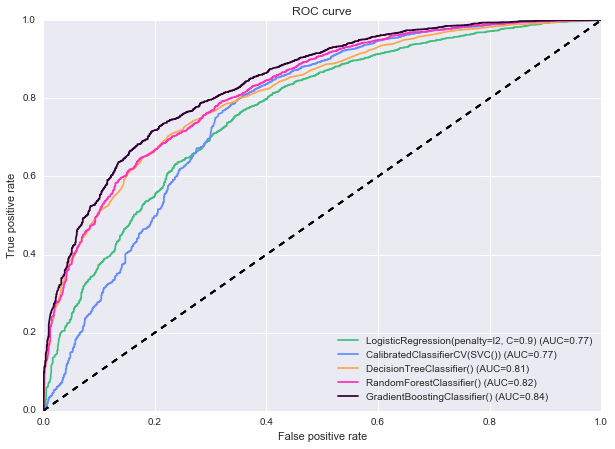

In [68]:
cu.roc_curves_4_clfs(clfs, X_valid, y_valid, labels)